In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('Reviews.csv')

In [3]:
df = df.head(500)

In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


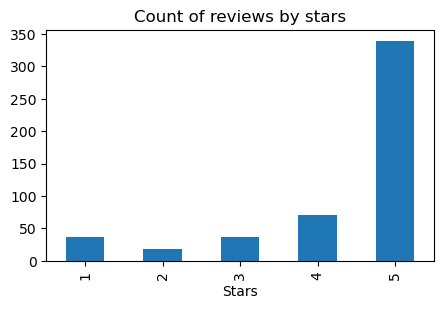

In [5]:
df['Score'].value_counts().sort_index().plot(kind='bar', figsize=(5,3), title='Count of reviews by stars',xlabel='Stars');

In [6]:
sia = SentimentIntensityAnalyzer()

In [7]:
example = df['Text'][50]

In [8]:
example

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [9]:
polarity_scores = sia.polarity_scores(example)

In [10]:
polarity_scores

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [11]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    pol_scores = sia.polarity_scores(text)
    res[myid] = pol_scores                              

  0%|          | 0/500 [00:00<?, ?it/s]

In [12]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df,how='left')

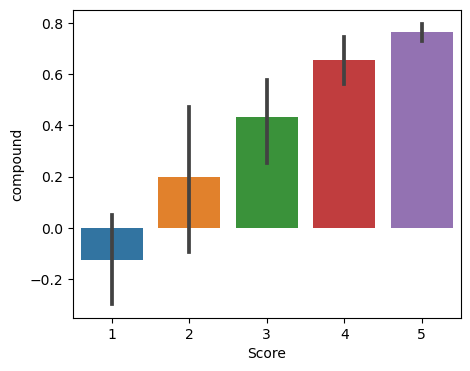

In [13]:
plt.figure(figsize=(5,4));
sb.barplot(data=vaders, x='Score', y='compound');

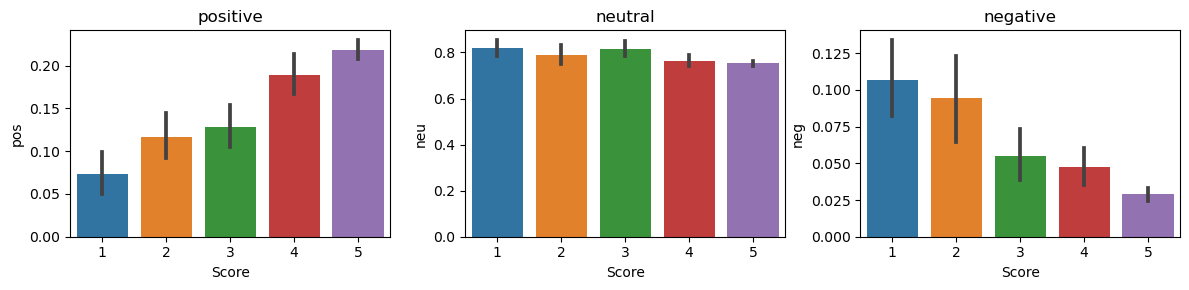

In [14]:
fig, axis = plt.subplots(1,3,figsize=(12,3))
sb.barplot(data=vaders,x='Score',y='pos',ax=axis[0])
sb.barplot(data=vaders,x='Score',y='neu',ax=axis[1])
sb.barplot(data=vaders,x='Score',y='neg',ax=axis[2])
axis[0].set_title('positive')
axis[1].set_title('neutral')
axis[2].set_title('negative')
plt.tight_layout()
plt.show()

In [15]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [16]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)       

In [17]:
x = sia.polarity_scores(example)
x

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [18]:
vector = tokenizer(example,return_tensors='pt')

In [19]:
def roberta_polarity_score(text):
    vector = tokenizer(text,return_tensors='pt')
    output = model(**vector)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg':scores[0],
        'roberta_neu':scores[1],
        'roberta_pos':scores[2]
    }
    return scores_dict

In [24]:
res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_scores = sia.polarity_scores(text)
        vader_scores_rename = {}
        for key,value in vader_scores.items():
            vader_scores_rename[f"vader_{key}"] = value
        roberta_scores = roberta_polarity_score(text)
        combined = {**vader_scores_rename,**roberta_scores}
        res[myid] = combined
    except RuntimeError:
        print(f'Cannot process {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Cannot process 83
Cannot process 187


In [31]:
results = pd.DataFrame(res).T
results = results.reset_index().rename(columns={'index':'Id'})
results = results.merge(df,how='left')                            

In [32]:
results

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452413,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,496,0.000,0.554,0.446,0.9725,0.001906,0.009862,0.988232,B000G6RYNE,APGAA43E3WPN7,Darren,0,0,5,1201392000,amazing chips,i rarely eat chips but i saw these and tried t...
494,497,0.059,0.799,0.142,0.7833,0.004415,0.034215,0.961369,B000G6RYNE,ABR7HU5H1KNE,Keith,0,0,5,1196726400,Best Chip Ever,This is easily the best potato chip that I hav...
495,498,0.025,0.762,0.212,0.9848,0.006427,0.074537,0.919036,B000G6RYNE,AJQD2WWJYOYFQ,bubbles,0,0,4,1186617600,"Tangy, spicy, and sweet- oh my!",Kettle Chips Spicy Thai potato chips have the ...
496,499,0.041,0.904,0.055,0.1280,0.865614,0.119366,0.015020,B000G6RYNE,A16YH487W9ZYO0,Bruce G. Lindsay,0,0,4,1184198400,An indulgence with a bite,"Okay, I should not eat potato chips, nor shoul..."


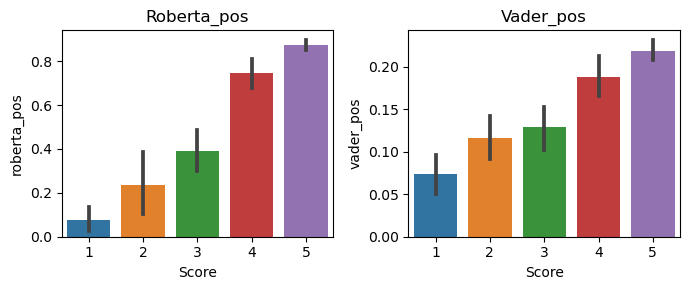

In [35]:
fig, axis = plt.subplots(1,2,figsize=(7,3))
sb.barplot(data=results,x='Score',y='roberta_pos',ax=axis[0])
sb.barplot(data=results,x='Score',y='vader_pos',ax=axis[1])
axis[0].set_title('Roberta_pos')
axis[1].set_title('Vader_pos')
plt.tight_layout()
plt.show()

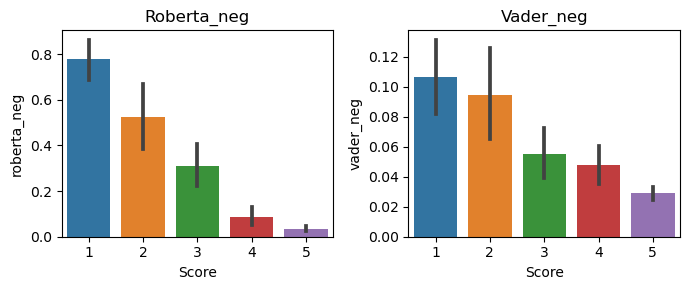

In [40]:
fig, axis = plt.subplots(1,2,figsize=(7,3))
sb.barplot(data=results,x='Score',y='roberta_neg',ax=axis[0])
sb.barplot(data=results,x='Score',y='vader_neg',ax=axis[1])
axis[0].set_title('Roberta_neg')
axis[1].set_title('Vader_neg')
plt.tight_layout()
plt.show()

In [50]:
results.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452413,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Comparing vader and roberta models

In [48]:
results.query('Score == 3').sort_values('roberta_neu',ascending=False)['Text'].values[0]

'I purchased it because it was on sale. In terms of the energy it provides, it works, but the taste leaves something to be desired. I tried mixing it with some water to make it more drinkable.'

In [53]:
results.query('Score == 3').sort_values('vader_neu',ascending=False)['Text'].values[0]

"This seems a little more wholesome than some of the supermarket brands, but it is somewhat mushy and doesn't have quite as much flavor either.  It didn't pass muster with my kids, so I probably won't buy it again."

### This text seems negative, but vader predicted it as neutral, let's see how roberta does on this text

In [64]:
results.iloc[45]['Text']

"This seems a little more wholesome than some of the supermarket brands, but it is somewhat mushy and doesn't have quite as much flavor either.  It didn't pass muster with my kids, so I probably won't buy it again."

In [61]:
results.iloc[45]['roberta_neg'],results.iloc[45]['vader_neg']

(0.886887788772583, 0.0)

### Let's look at some examples where score = 5 ( that means the text should probably be positive) and given highest negative amoung the score=5

In [74]:
results.query('Score==5').sort_values('vader_neg',ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

### This has a score=5, the comment does not show any negativity regarding the product, but the sentiment in the comment is actually negative.

In [75]:
results.query('Score==5').sort_values('vader_neg',ascending=False)['vader_neg'][69]

0.344

### And Roberta model confidentally predicted this text as negative.

In [76]:
results.iloc[69]['roberta_neg']

0.9601579308509827

### Let's look at some examples where score = 1 ( that means the text should probably be negative) and given highest positive amoung the score=1

In [85]:
results.query('Score==1').sort_values('vader_pos',ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

### Seems they are being sarcastic but the sentiment seems to be positive

In [86]:
results.iloc[322]['vader_pos'],results.iloc[322]['roberta_pos']

(0.274, 0.6071789264678955)

In [100]:
results.query('Score==1').sort_values('roberta_pos',ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [95]:
results.query('Score==1').sort_values('vader_pos',ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [90]:
results.query('Score==5').sort_values('vader_pos',ascending=False)['Text'].values[0]

'This is an great product. The taste is great, and it works exactly as described. Superb natural sleep aid. AMAZING!'

In [94]:
results.query('Score==5').sort_values('roberta_pos',ascending=False)['Text'].values[0]

"These are my favorite bars ever. The combo of raisons and dark choc is wonderful! Very filling! These are hard to find in the stores. I'm thankful for subsrcibe and save!"